# Colour - HDRI - Examples: Merge from Raw Files

Through this example, some Canon EOS 5D Mark II *CR2* files will be merged together in order to create a single radiance image.

The following steps will be taken:

- Conversion of the *CR2* files to *DNG* files using [Adobe DNG Converter](http://www.adobe.com/support/downloads/detail.jsp?ftpID=5957).
- Conversion of the *DNG* files to intermediate demosaiced linear *Tiff* files using Dave Coffin's [dcraw](https://www.cybercom.net/~dcoffin/dcraw/).
- Creation of an image stack using *DNG* and intermediate *Tiff* files:
    - Reading of the *DNG* files *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the intermediate *Tiff* files pixel data using [OpenImageIO](http://openimageio.org/).
    - White balancing of the intermediate *Tiff* files.
    - Conversion of the intermediate *Tiff* files to *RGB* display colourspace.
- Merging of the image stack into a radiance image.
- Display of the final resulting radiance image.

> Note: Some steps can be performed using alternative methods or simplified, for instance the *DNG* conversion can be entirely avoided. Our interest here is to retrieve the camera levels and the [Adobe DNG](https://helpx.adobe.com/photoshop/digital-negative.html) camera colour profiling data.

## CR2 Files Conversion to DNG and Intermediate Files

In [1]:
%matplotlib inline

In [2]:
import logging
import numpy as np
import os

import colour
from colour.plotting import *

from colour_hdri import (
    EXAMPLES_RESOURCES_DIRECTORY,
    Image,
    ImageStack,
    camera_space_to_sRGB,
    convert_dng_files_to_intermediate_files,
    convert_raw_files_to_dng_files,
    filter_files,
    read_exif_tag,
    highlights_recovery_blend,
    image_stack_to_radiance_image,
    update_exif_tags,
    weighting_function_Debevec1997)
from colour_hdri.plotting import radiance_image_strip_plot

colour.utilities.filter_warnings(True, False)

colour_plotting_defaults()

logging.basicConfig(level=logging.DEBUG)

OETF = colour.OETFS['sRGB']

RESOURCES_DIRECTORY = os.path.join(EXAMPLES_RESOURCES_DIRECTORY,
                                   'frobisher_001')

In [3]:
RAW_FILES = filter_files(RESOURCES_DIRECTORY, ('CR2',))

DNG_FILES = convert_raw_files_to_dng_files(RAW_FILES, RESOURCES_DIRECTORY)
    
INTERMEDIATE_FILES = convert_dng_files_to_intermediate_files(
    DNG_FILES, RESOURCES_DIRECTORY, demosaicing=True)

update_exif_tags(zip(DNG_FILES, INTERMEDIATE_FILES))

XYZ_TO_CAMERA_SPACE_MATRIX = colour.utilities.as_float_array(
    map(float, read_exif_tag(DNG_FILES[-2],
                         'ColorMatrix2').split())).reshape((3, 3))

INFO:colour_hdri.process.dng:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.dng" file.
INFO:colour_hdri.process.dng:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-dataset/frobisher_001/IMG_2599.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-dataset/frobisher_001/IMG_2599.dng" file.
INFO:colour_hdri.process.dng:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-dataset/frobisher_001/IMG_2600.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-data

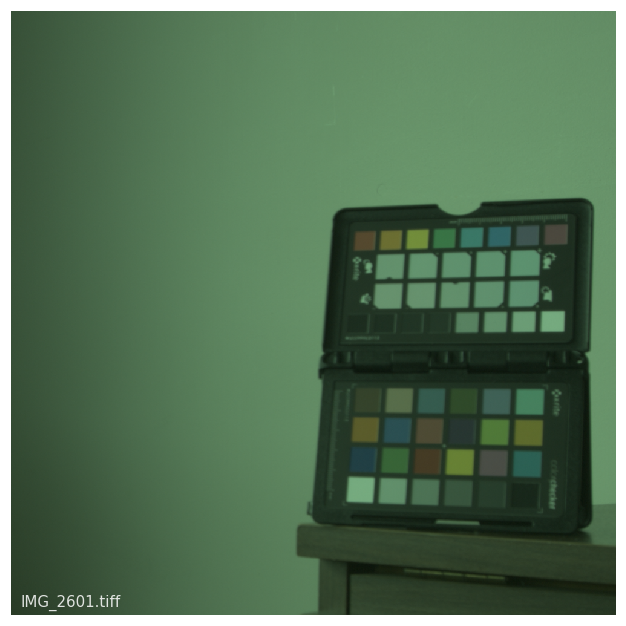

In [4]:
image_plot(OETF(colour.read_image(
            str(INTERMEDIATE_FILES[-2]))[1250:2250, 3000:4000, ...]),
           os.path.basename(INTERMEDIATE_FILES[-2]))

## Radiance Image Merge

In [5]:
def merge_from_raw_files(
        dng_files,
        output_directory,
        batch_size=5,
        white_balance_multipliers=None,
        weighting_function=weighting_function_Debevec1997):
    paths = []
    for dng_files in colour.utilities.batch(dng_files, batch_size):
        image_stack = ImageStack()
        for dng_file in dng_files:
            image = Image(dng_file)
            image.read_metadata()
            image.path = str(dng_file.replace('dng', 'tiff'))
            image.read_data()
            white_balance_multipliers_e = np.power(
                image.metadata.white_balance_multipliers, -1)
            logging.info('\tWhite Balance Multipliers (Exif): {0}'.format(
                white_balance_multipliers_e))
            white_balance_multipliers = (
                white_balance_multipliers
                if white_balance_multipliers is not None
                else white_balance_multipliers_e)
            logging.info('\tWhite Balance Multipliers (Used): {0}'.format(
                white_balance_multipliers))
            # Avoiding white balance normalisation thus avoiding highlights
            # recovery as weighting will exclude saturated luminance values.             
            # white_balance_multipliers /= np.max(white_balance_multipliers)
            image_data = image.data * white_balance_multipliers
            # image_data = highlights_recovery_blend(
            #    image.data * white_balance_multipliers,
            #    white_balance_multipliers)
            image.data = camera_space_to_sRGB(image_data,
                                              XYZ_TO_CAMERA_SPACE_MATRIX)
            image_stack.append(image)

        path = os.path.join(
            output_directory,
            '{0}_{1}_MRF.{2}'.format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                'exr'))
        paths.append(path)

        logging.info('Merging "{0}"...'.format(path))
        logging.info('\tImage stack "F Number" (Exif): {0}'.format(
            image_stack.f_number))
        logging.info('\tImage stack "Exposure Time" (Exif): {0}'.format(
            image_stack.exposure_time))
        logging.info('\tImage stack "ISO" (Exif): {0}'.format(
            image_stack.iso))
        image = image_stack_to_radiance_image(image_stack,
                                              weighting_function,
                                              weighting_average=True)

        logging.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)

    return paths


PATHS = merge_from_raw_files(DNG_FILES, RESOURCES_DIRECTORY)

INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.dng" image metadata.
INFO:colour_hdri.utilities.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.dng' image exif data.
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.tiff" image.
INFO:root:	White Balance Multipliers (Exif): [ 2.42089718  1.          1.54687415]
INFO:root:	White Balance Multipliers (Used): [ 2.42089718  1.          1.54687415]
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-dataset/frobisher_001/IMG_2599.dng" image metadata.
INFO:colour_hdri.utilities.exi

## Radiance Image Display

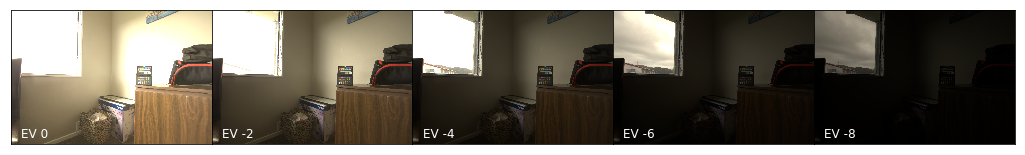

In [6]:
radiance_image_strip_plot(colour.read_image(PATHS[0]))